833.6107788085938
http://www.loc.gov/rr/scitech/subjectguides/images/tesla-new.jpg


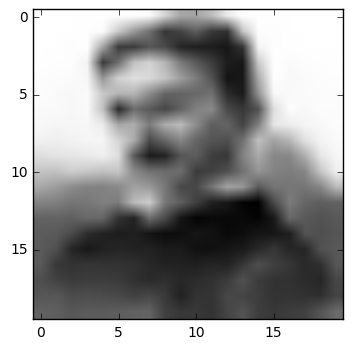

C:\Users\rames\Anaconda3\lib\site-packages\ipykernel\__main__.py:187: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


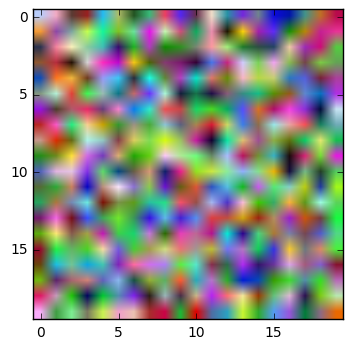

http://listverse.com/wp-content/uploads/2009/02/godfreykneller-isaacnewton-1689.jpg.jpeg


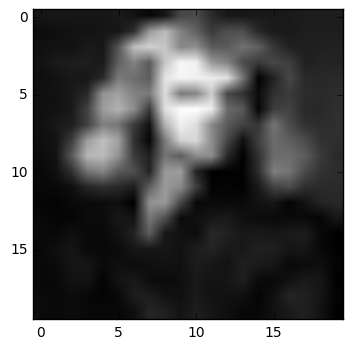

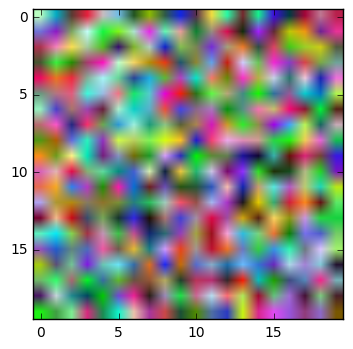

http://listverse.com/wp-content/uploads/2009/02/godfreykneller-isaacnewton-1689.jpg.jpeg


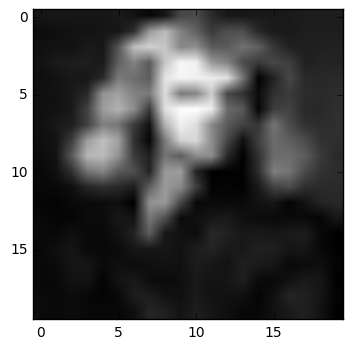

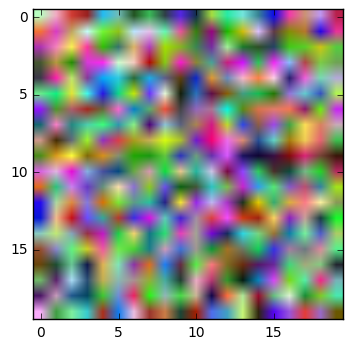

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd660e4b089801fe7e3d9/1458152617516/SciSource_BK0929.jpg?format=750w


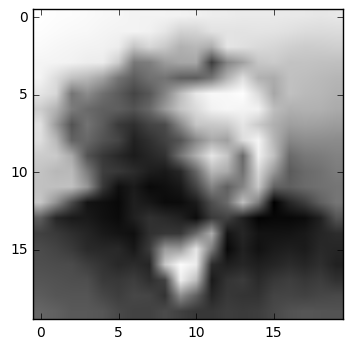

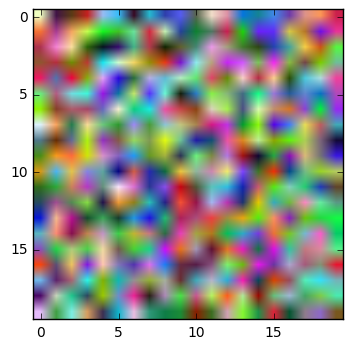

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd28be4b0c47638e2f540/1458152692173/SciSource_BN4337.jpg?format=750w


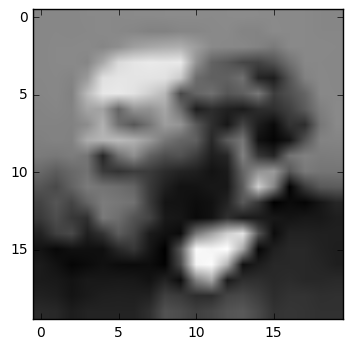

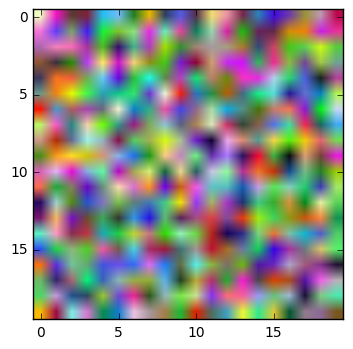

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd532e4b0141d9ac95e95/1458152729573/SciSource_BK0945.jpg?format=750w


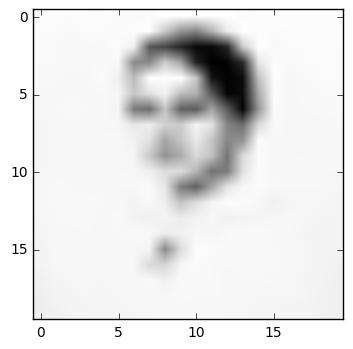

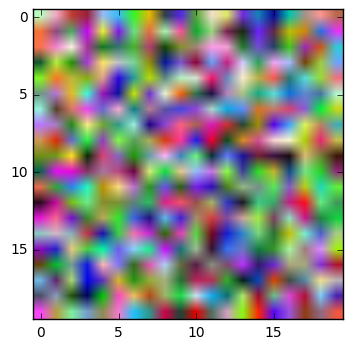

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/5400dbd4e4b0fc8cd2ef213e/1458152745999/SciSource_BU1440.jpg?format=750w


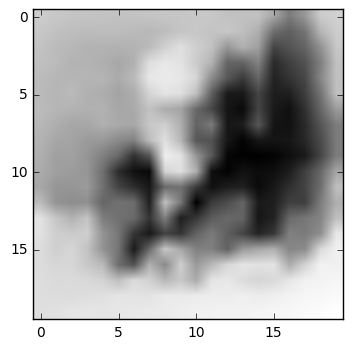

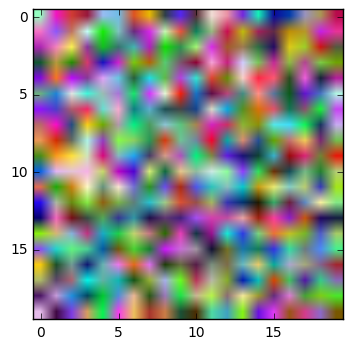

In [1]:
import theano 
from theano import tensor as T 
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams 
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
from theano.compile.nanguardmode import NanGuardMode

srng = RandomStreams()

def argmaxIdx(X):
    mIdx = 0
    max = 0.0
    for i in range(len(X)):
        if X[i] > max:
            max = X[i]
            mIdx = i
    return mIdx
    
def dropout(X, p=0.): 
    if p > 0: 
        retain_prob = 1 - p 
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) 
        X /= retain_prob 
    return X 

def rectify(X): 
    return T.maximum(X, 0.000001) 

def softmax(X):     
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x')) 
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x') 

def log_softmax(q):
    max_q = max(0.0, np.max(q))
    rebased_q = q - max_q
    return rebased_q - np.logaddexp(-max_q, np.logaddexp.reduce(rebased_q))

def floatX(X): 
    return np.asarray(X, dtype=theano.config.floatX) 

def init_weights(shape): 
    return theano.shared(floatX(np.random.randn(*shape) * 0.01)) 

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6): 
    grads = T.grad(cost=cost, wrt=params) 
    updates = [] 
    for p, g in zip(params, grads): 
        acc = theano.shared(p.get_value() * 0.) 
        acc_new = rho * acc + (1 - rho) * g ** 2 
        gradient_scaling = T.sqrt(acc_new + epsilon) 
        g = g / gradient_scaling 
        updates.append((acc, acc_new)) 
        updates.append((p, p - lr * g)) 
    return updates 

w_h1 = init_weights((400, 100)) 
w_h2 = init_weights((100, 200)) 
w_h3 = init_weights((200, 500)) 
w_h4 = init_weights((500, 1000)) 
w_h5 = init_weights((1000, 307200)) 

def model(X,w_h1,w_h2,w_h3,w_h4, w_h5, p_drop_input=0.0, p_drop_hidden=0.0):
    X = dropout(X, p_drop_input) 
    w_o_h1=T.nnet.sigmoid(T.dot(X, w_h1)) 
    w_o_h1= dropout(w_o_h1, p_drop_input) 
    w_o_h2=T.nnet.sigmoid(T.dot(w_o_h1, w_h2)) 
    w_o_h2= dropout(w_o_h2, p_drop_input) 
    w_o_h3=T.nnet.sigmoid(T.dot(w_o_h2, w_h3)) 
    w_o_h3= dropout(w_o_h3, p_drop_input) 
    w_o_h4=T.nnet.sigmoid(T.dot(w_o_h3, w_h4)) 
    w_o_h4= dropout(w_o_h4, p_drop_input)     
    y_x = T.nnet.sigmoid(T.dot(w_o_h4, w_h5)) 
    return y_x 


X = T.fmatrix() 
Y = T.fmatrix() 

y_x = model(X,w_h1,w_h2,w_h3,w_h4, w_h5, 0.1,0.1)

cost = T.mean(T.nnet.categorical_crossentropy(y_x, Y))
params = [w_h1,w_h2,w_h3]
updates = RMSprop(cost, params, lr=0.0001) 
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True) 
predict = theano.function(inputs=[X], outputs=y_x, mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True),allow_input_downcast=True) 

import PIL
from PIL import Image
import requests
from io import BytesIO

np.set_printoptions(threshold=np.inf)

images = dict()

for i in range(1):
    with open("../Environment/Informations/Content/Portraits/trainImages/images.txt") as f:
        infoFileContents = f.readlines()
        for l in range(len(infoFileContents)):
            infoLine = infoFileContents[l].lstrip().rstrip()
            
            trainImg = ''
            if infoLine in images:
                trainImg = images[infoLine]
            else:
                response = requests.get(infoLine)
                images[infoLine] = Image.open(BytesIO(response.content))
                trainImg = images[infoLine]
                
            trainInpImg = trainImg 
            trainInpGrayImg = trainInpImg.convert("L")
            trainInpGrayImg = trainInpGrayImg.resize((20,20), PIL.Image.ANTIALIAS)
            trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.uint8).ravel()
            trainInpGreyImgArrayNorm = trainInpGreyImgArray/255.0
            #print (len(trainInpGreyImgArray))
            
            #print (trainInpGreyImgArray)

            #plt.imshow(trainInpGrayImg, cmap = cm.Greys_r)
            #plt.show()

            trainOutImg = trainImg
            trainOutImg = trainOutImg.convert("RGB")
            trainOutImg = trainOutImg.resize((20,20), PIL.Image.ANTIALIAS)
            
            #plt.imshow(trainOutImg)
            #plt.show()
            
            trainOut3dArray = np.asarray(trainOutImg, dtype=np.uint8)
            trainOut3dArrayClone = np.empty_like (trainOut3dArray)
            trainOut3dArrayClone[:] = trainOut3dArray
 
            #trainOut3dArrayClone[:,:,1:3] = 0
            trainOutImgArray  = np.rollaxis(trainOut3dArrayClone, 2)
            #trainOutImgArray = trainOutImgArray.ravel()[0:2500]
            trainOutImgArray = trainOutImgArray.ravel()
            
            trainEncodedOutArray = np.empty([3*20*20*256], dtype=np.uint8)
            #trainOutImgArray /= 255.0
            
            for x, value in np.ndenumerate(trainOutImgArray):
                for enIdx in range(256):
                    if enIdx == value:
                        trainEncodedOutArray[x[0]*256 + enIdx] = 1
                    else:
                        trainEncodedOutArray[x[0]*256 + enIdx] = 0
                        
            #print (trainEncodedOutArray)
            cost = train([trainInpGreyImgArrayNorm], [trainEncodedOutArray])
            print (cost)

for i in range(1):
    with open("../Environment/Informations/Content/Portraits//testImages/images.txt") as f:
        infoFileContents = f.readlines()
        for l in range(len(infoFileContents)):
            infoLine = infoFileContents[l].lstrip().rstrip()
            response = requests.get(infoLine)

            if infoLine in images:
                trainImg = images[infoLine]
            else:
                response = requests.get(infoLine)
                images[infoLine] = Image.open(BytesIO(response.content))
                trainImg = images[infoLine]

            print (infoLine)
            trainInpImg = Image.open(BytesIO(response.content))
            trainInpGrayImg = trainInpImg.convert("L")
            trainInpGrayImg = trainInpGrayImg.resize((20,20), PIL.Image.ANTIALIAS)
            trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.uint8).ravel()
            #trainInpGreyImgArray /= 255.0

            #trainInpGrayImg.show()
            plt.imshow(trainInpGrayImg, cmap = cm.Greys_r)
            plt.show()

            predImgArray = predict([trainInpGreyImgArray])

            fnlDeCodedArray = np.empty([3*20*20], dtype=np.uint8)
            deCodedArray = np.empty([256], dtype=np.float32)
            for i in range(len(predImgArray[0])):
                if i > 0 and i%256 == 0:
                    deCodedValue = argmaxIdx(deCodedArray)
                    fnlDeCodedArray[(i/256)-1] = deCodedValue
                    deCodedArray = np.empty([256], dtype=np.float32)
                deCodedArray[i%256] = predImgArray[0][i]
               
            #print (fnlDeCodedArray)
            #print (predImgArray)
            #maxValue = np.max(predImgArray)
            #print (maxValue)
            #mulValue = 255.0/maxValue
            #print (mulValue)
            #predImgArray *= 255
            #print (predImgArray)
            #print (trainInpGreyImgArray)
            #print (predImgArray)
            #predImgArray *= 255.0


            fnlDeCodedArray = fnlDeCodedArray.reshape((3,20,20)).astype('uint8')    
            fnlDeCodedArray = np.rollaxis(fnlDeCodedArray, 2)
            fnlDeCodedArray = np.rollaxis(fnlDeCodedArray, 2)

            #print (predImgArray)
            #predImg3dArray = predImgArray.reshape((50,50)).astype('uint8')
            #predImg3dArray = np.rollaxis(predImg3dArray, 2)
            #predImg3dArray = np.rollaxis(predImg3dArray, 2)

            img = Image.fromarray(fnlDeCodedArray)

            #img.show()
            
            plt.imshow(img)
            plt.show()
        
